# **Hand Segmentation in Images**

**Created by: Boudjellal Sif Eddine**
[LinkedIn](https://www.linkedin.com/in/sif-eddine-boudjellal/)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
  - Install YOLOv8
  - import the necessary libraries
- Data Processing
  - Create new dataset structure
  - Auto-Annotation
  - Generate Segmentation Dataset Using YOLO8 and SAM
  - Create a new dataset with train/val sets
- Train YOLOv8 Instance Segmentation model
  - Custom Training
  - Validate Custom Model
  - Save Trained Model
- Background Removal

**Let's begin!**

#Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi`

In [ ]:
!nvidia-smi

Thu Sep 28 12:50:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install `YOLOv8`

In [ ]:
!pip install ultralytics

###Import the necessary libraries

In [ ]:
from IPython import display
display.clear_output()
from IPython.display import display, Image

In [ ]:

import os
import cv2
import numpy as np
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

#Data Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First, let's access the Dataset and extract it

In [ ]:
file_path='/content/drive/MyDrive/public_hand_dataset.zip'
destination = '/content/dataset.zip'
shutil.copyfile(file_path, destination)

'/content/dataset.zip'

In [ ]:
!unzip '/content/dataset.zip'

##Create new dataset structure

Now, we will change the dataset structure to the as follows:
```
_dataset/
├── no_bg/
│   ├── Images/
│   └── ...
└── original/
    ├── Images/
    └── ...
```


In [ ]:

source_dir = '/content/public_hand_dataset'
output_dir = '/content/dataset'

os.makedirs(output_dir, exist_ok=True)
for cls in tqdm(os.listdir(source_dir)):
  img_path = os.path.join(os.path.join(source_dir, cls))
  for folder in ['no_bg', 'original']:
    imgs = os.listdir(os.path.join(img_path, folder))
    for img in imgs:
      src_path = os.path.join(img_path, folder, img)
      dest_dir = os.path.join(output_dir, folder)
      os.makedirs(dest_dir, exist_ok=True)
      dest_path= os.path.join(dest_dir,f'{img_path.split("/")[-1]}'+'.jpeg')
      shutil.copy(src_path, dest_path)

100%|██████████| 150/150 [00:04<00:00, 33.42it/s]


Delete the old files

In [ ]:
! rm /content/dataset.zip\
  && rm -rf  /content/public_hand_dataset

Plotting an image with its segment image

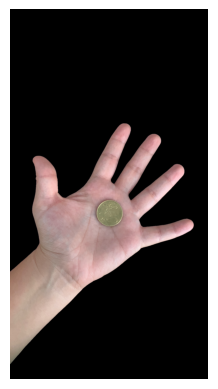

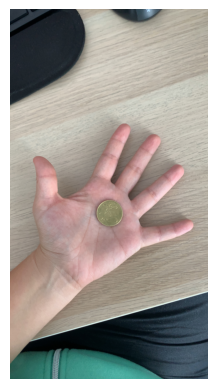

In [ ]:
no_bg_img='/content/dataset/no_bg/100328385179725049535622994313026736131.jpeg'
original_img='/content/dataset/original/100328385179725049535622994313026736131.jpeg'
for path in [no_bg_img,original_img]:
  image = cv2.imread(path)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  plt.axis('off')
  plt.show()


##Auto-Annotation

Auto-annotation is an essential feature that allows you to generate a segmentation dataset using a pre-trained detection model. It enables you to quickly and accurately annotate a large number of images without the need for manual labeling, saving time and effort.

###Introduction to SAM: The Segment Anything Model
The Segment Anything Model, or SAM, is a cutting-edge image segmentation model that allows for promptable segmentation, providing unparalleled versatility in image analysis tasks. SAM forms the heart of the Segment Anything initiative, a groundbreaking project that introduces a novel model, task, and dataset for image segmentation.

For more: [Segment Anything Model](https://segment-anything.com/)

##Generate Segmentation Dataset Using YOLO8 and SAM

The auto_annotate function takes the path to your images, along with optional arguments for specifying the pre-trained detection and SAM segmentation models.

For more: [Auto-Annotation](https://docs.ultralytics.com/datasets/segment/)

In [ ]:
#Create an new folder
!mkdir ./dataset/annotate

In [ ]:
from ultralytics.data.annotator import auto_annotate

auto_annotate(
             data="./dataset/no_bg",
              det_model="yolov8x.pt",
              sam_model='sam_l.pt',output_dir='./dataset/annotate',
              )


100%|██████████| 1.16G/1.16G [00:18<00:00, 65.9MB/s]

image 1/150 /content/dataset/no_bg/100328385179725049535622994313026736131.jpeg: 640x352 1 person, 80.2ms
image 2/150 /content/dataset/no_bg/101246170554525927110592012192635617282.jpeg: 640x352 1 person, 27.9ms
image 3/150 /content/dataset/no_bg/102586421877817102033289037136558555138.jpeg: 640x352 1 person, 28.3ms
image 4/150 /content/dataset/no_bg/103533371160311057344050207338041835522.jpeg: 640x480 1 person, 115.3ms
image 5/150 /content/dataset/no_bg/105191087023147597386443061825746960386.jpeg: 640x352 1 person, 1 mouse, 29.3ms
image 6/150 /content/dataset/no_bg/105729964990523101556623657143682138114.jpeg: 640x384 1 person, 1 toothbrush, 113.3ms
image 7/150 /content/dataset/no_bg/109835641420375699830247193885099884546.jpeg: 640x352 1 person, 29.5ms
image 8/150 /content/dataset/no_bg/111214890097383179438014223563034984450.jpeg: 640x352 1 person, 27.8ms
image 9/150 /content/dataset/no_bg/11240591741781235909495687524067881779

###Note: ***To get more accurate annotation results, we will annotate the segment images***



##Split the Dataset into Train/Val sets

**Now, we split the dataset into train/val sets with 80% for training and 20% for validation**

In [ ]:
total_images = len(os.listdir('./dataset/annotate'))
train_size = int(0.8 * total_images)

#get all image IDs
ids=[]
for idx in tqdm(os.listdir('./dataset/annotate')):
  ids.append(idx)

# Randomly shuffle the image IDs
random.shuffle(ids)
# Split the image IDs into train and validation sets
train_image_ids = ids[:train_size]
val_image_ids = ids[train_size:]

100%|██████████| 149/149 [00:00<00:00, 847966.48it/s]


In [ ]:
print('validation data length:',len(val_image_ids))
print('Train data length:',len(train_image_ids))

validation data length: 30
Train data length: 119


##Create a new dataset with train/val sets

In [ ]:
!mkdir -p ./datasets/new_dataset/train \
&& mkdir -p ./datasets/new_dataset/val \

In [ ]:
image_dir='/content/dataset/original'
ann_dir='/content/dataset/annotate'
dist_dir='./datasets/new_dataset'
for ann_id in tqdm(train_image_ids):
  image_id= ann_id.split('.')[0]+'.jpeg'
  # Copy the image file to the train directory
  src_image_path = os.path.join(image_dir,image_id)
  dst_image_path = os.path.join(dist_dir,'train', image_id)
  shutil.copy(src_image_path, dst_image_path)
  # Copy the annotate file to the train directory
  src_annotate_path = os.path.join(ann_dir,ann_id)
  dst_annotate_path = os.path.join(dist_dir,'train', ann_id)
  shutil.copy(src_annotate_path,  dst_annotate_path)

100%|██████████| 119/119 [00:00<00:00, 186.88it/s]


In [ ]:

for ann_id in tqdm(val_image_ids):
  image_id= ann_id.split('.')[0]+'.jpeg'
  # Copy the image file to the train directory
  src_image_path = os.path.join(image_dir,image_id)
  dst_image_path = os.path.join(dist_dir,'val', image_id)
  shutil.copy(src_image_path, dst_image_path)
  # Copy the annotate file to the train directory
  src_annotate_path = os.path.join(ann_dir,ann_id)
  dst_annotate_path = os.path.join(dist_dir,'val', ann_id)
  shutil.copy(src_annotate_path,  dst_annotate_path)

100%|██████████| 30/30 [00:00<00:00, 177.69it/s]


### Dataset YAML format:

The Ultralytics framework uses a YAML file format to define the dataset and model configuration for training Detection Models. Here is an example of the YAML format used for defining our dataset:

```
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ./new_dataset  # dataset root dir
train: train  # train images (relative to 'path') 4 images
val: val  # val images (relative to 'path') 4 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: hand
```

****Create a `dataset.yaml` file and copy the script, upload the `dataset.yaml` file to `./datasets`****

### we note that the segment images have `Hand` class and another few classes like (coin, ring...etc). in this task, we take only the `Hand` class and ignore the onther classes.

#Train YOLOv8 Instance Segmentation model

##Custom Training

**Here, we use the `yolov8m-seg` model.** you can choose another model.

we choose the num of `epochs=50`

In [ ]:
!yolo task=segment mode=train model=yolov8m-seg.pt data=./datasets/dataset.yaml epochs=70 imgsz=640

Ultralytics YOLOv8.0.188 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=./datasets/dataset.yaml, epochs=70, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, opt

In [ ]:
!ls ./runs/segment/train/

args.yaml					    MaskR_curve.png
BoxF1_curve.png					    results.csv
BoxP_curve.png					    results.png
BoxPR_curve.png					    train_batch0.jpg
BoxR_curve.png					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch2.jpg
confusion_matrix.png				    train_batch420.jpg
events.out.tfevents.1695905963.d81ee8bb70ee.3821.0  train_batch421.jpg
labels_correlogram.jpg				    train_batch422.jpg
labels.jpg					    val_batch0_labels.jpg
MaskF1_curve.png				    val_batch0_pred.jpg
MaskP_curve.png					    weights
MaskPR_curve.png


###Visualize the results of the train phase.

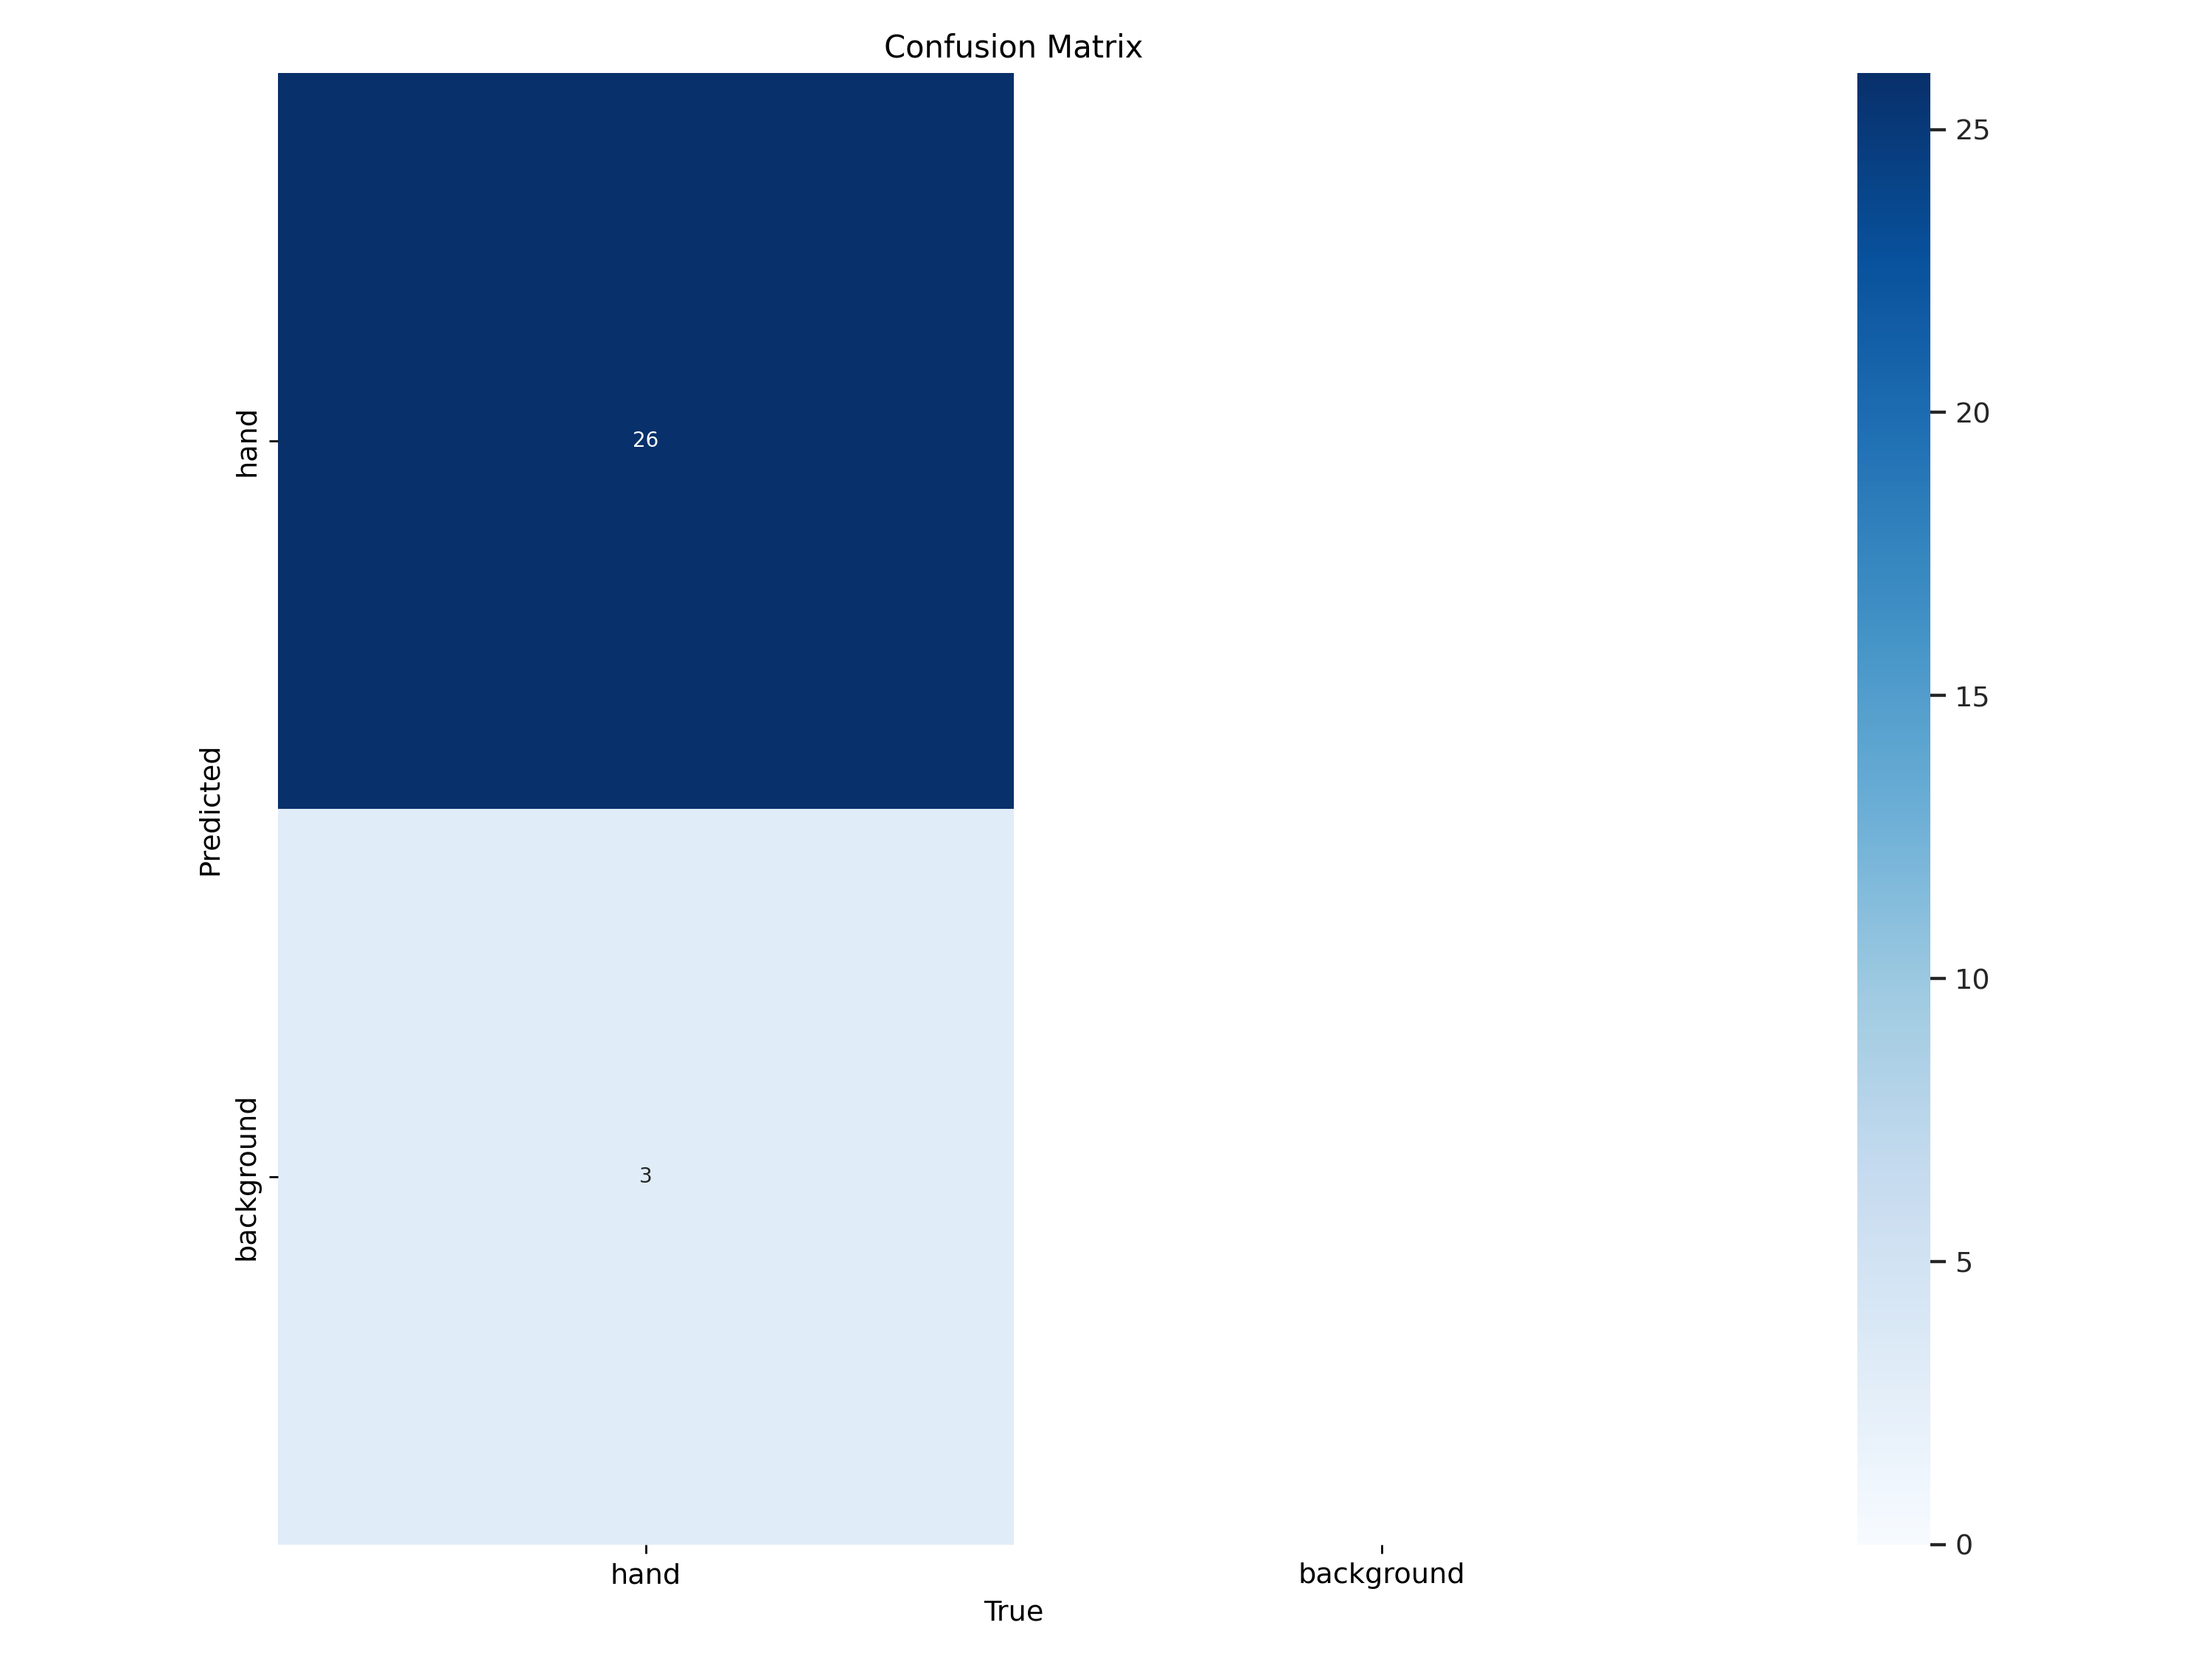

In [ ]:
Image(filename='./runs/segment/train/confusion_matrix.png', width=600)

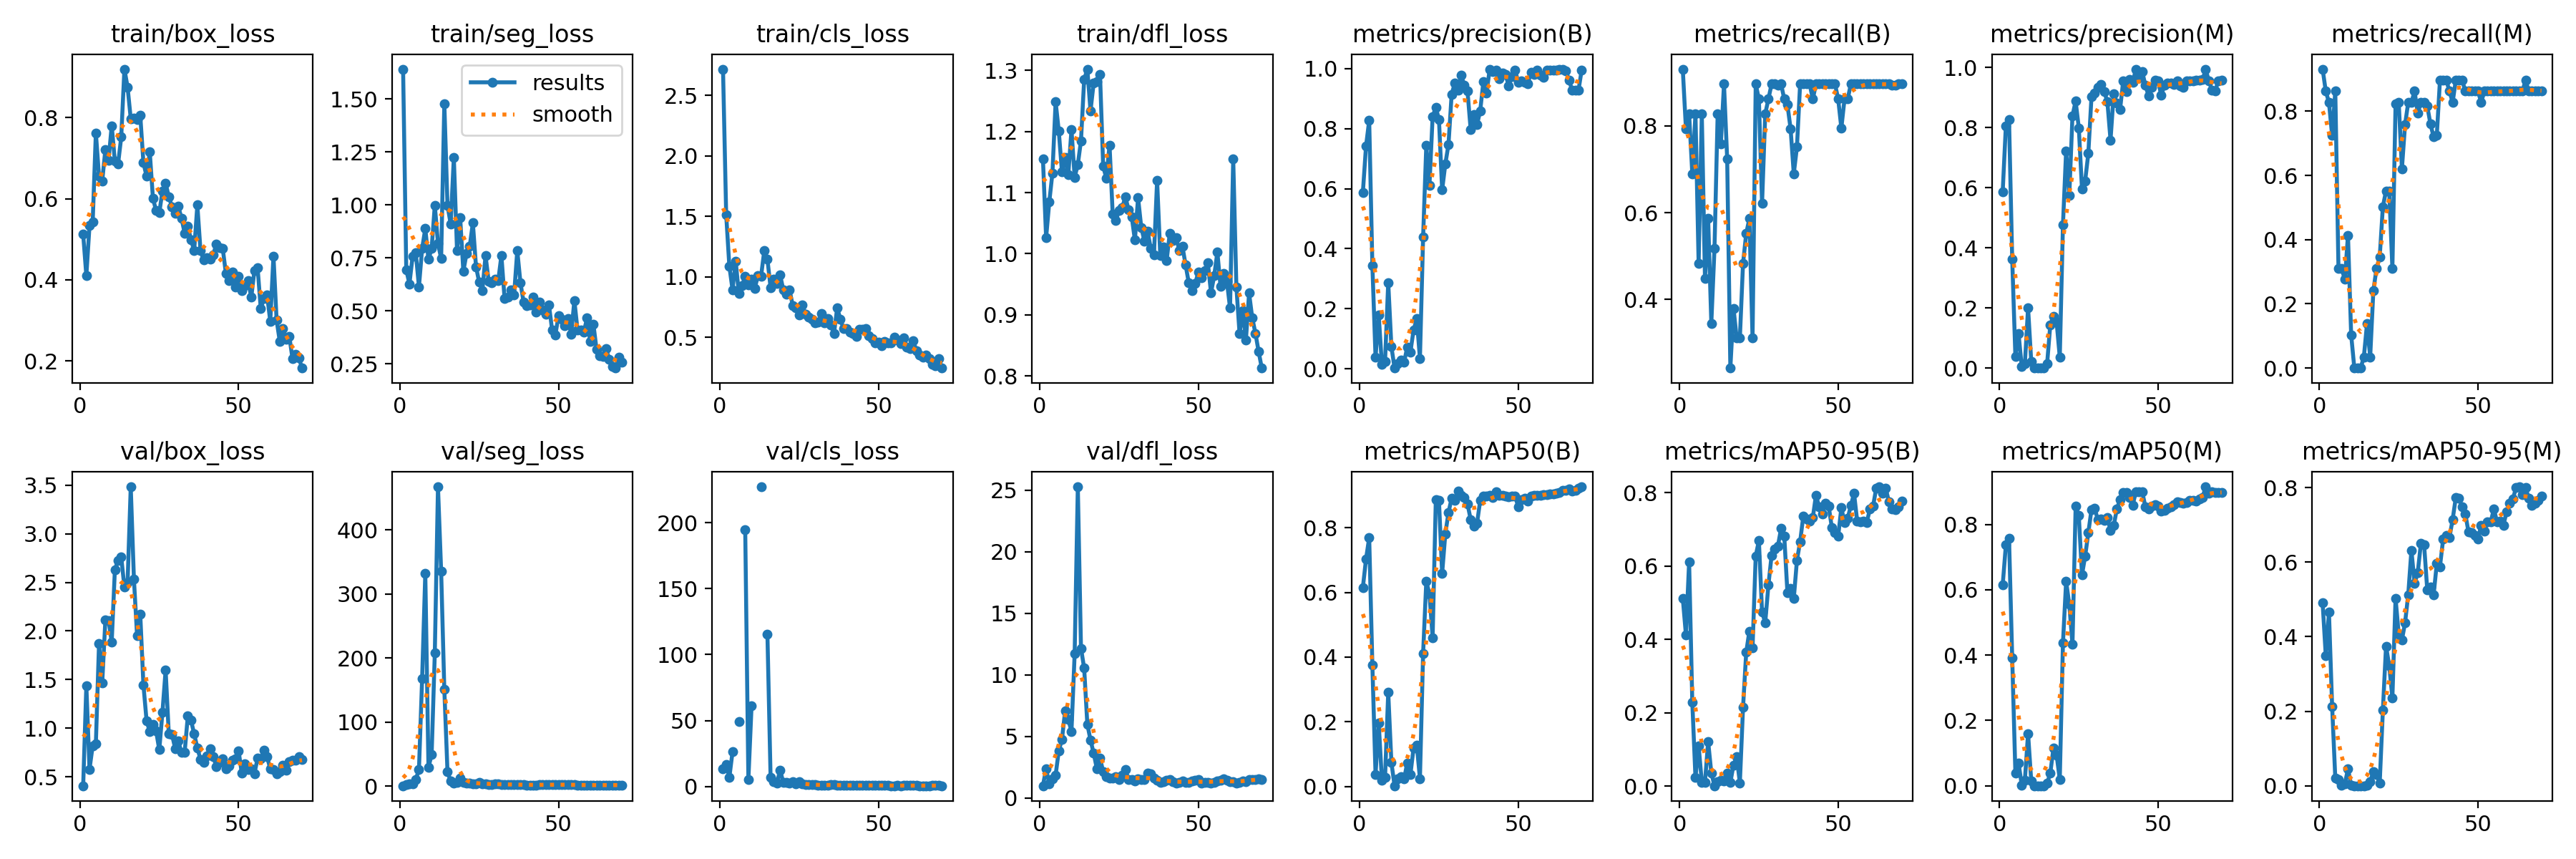

In [ ]:
Image(filename='./runs/segment/train/results.png', width=600)

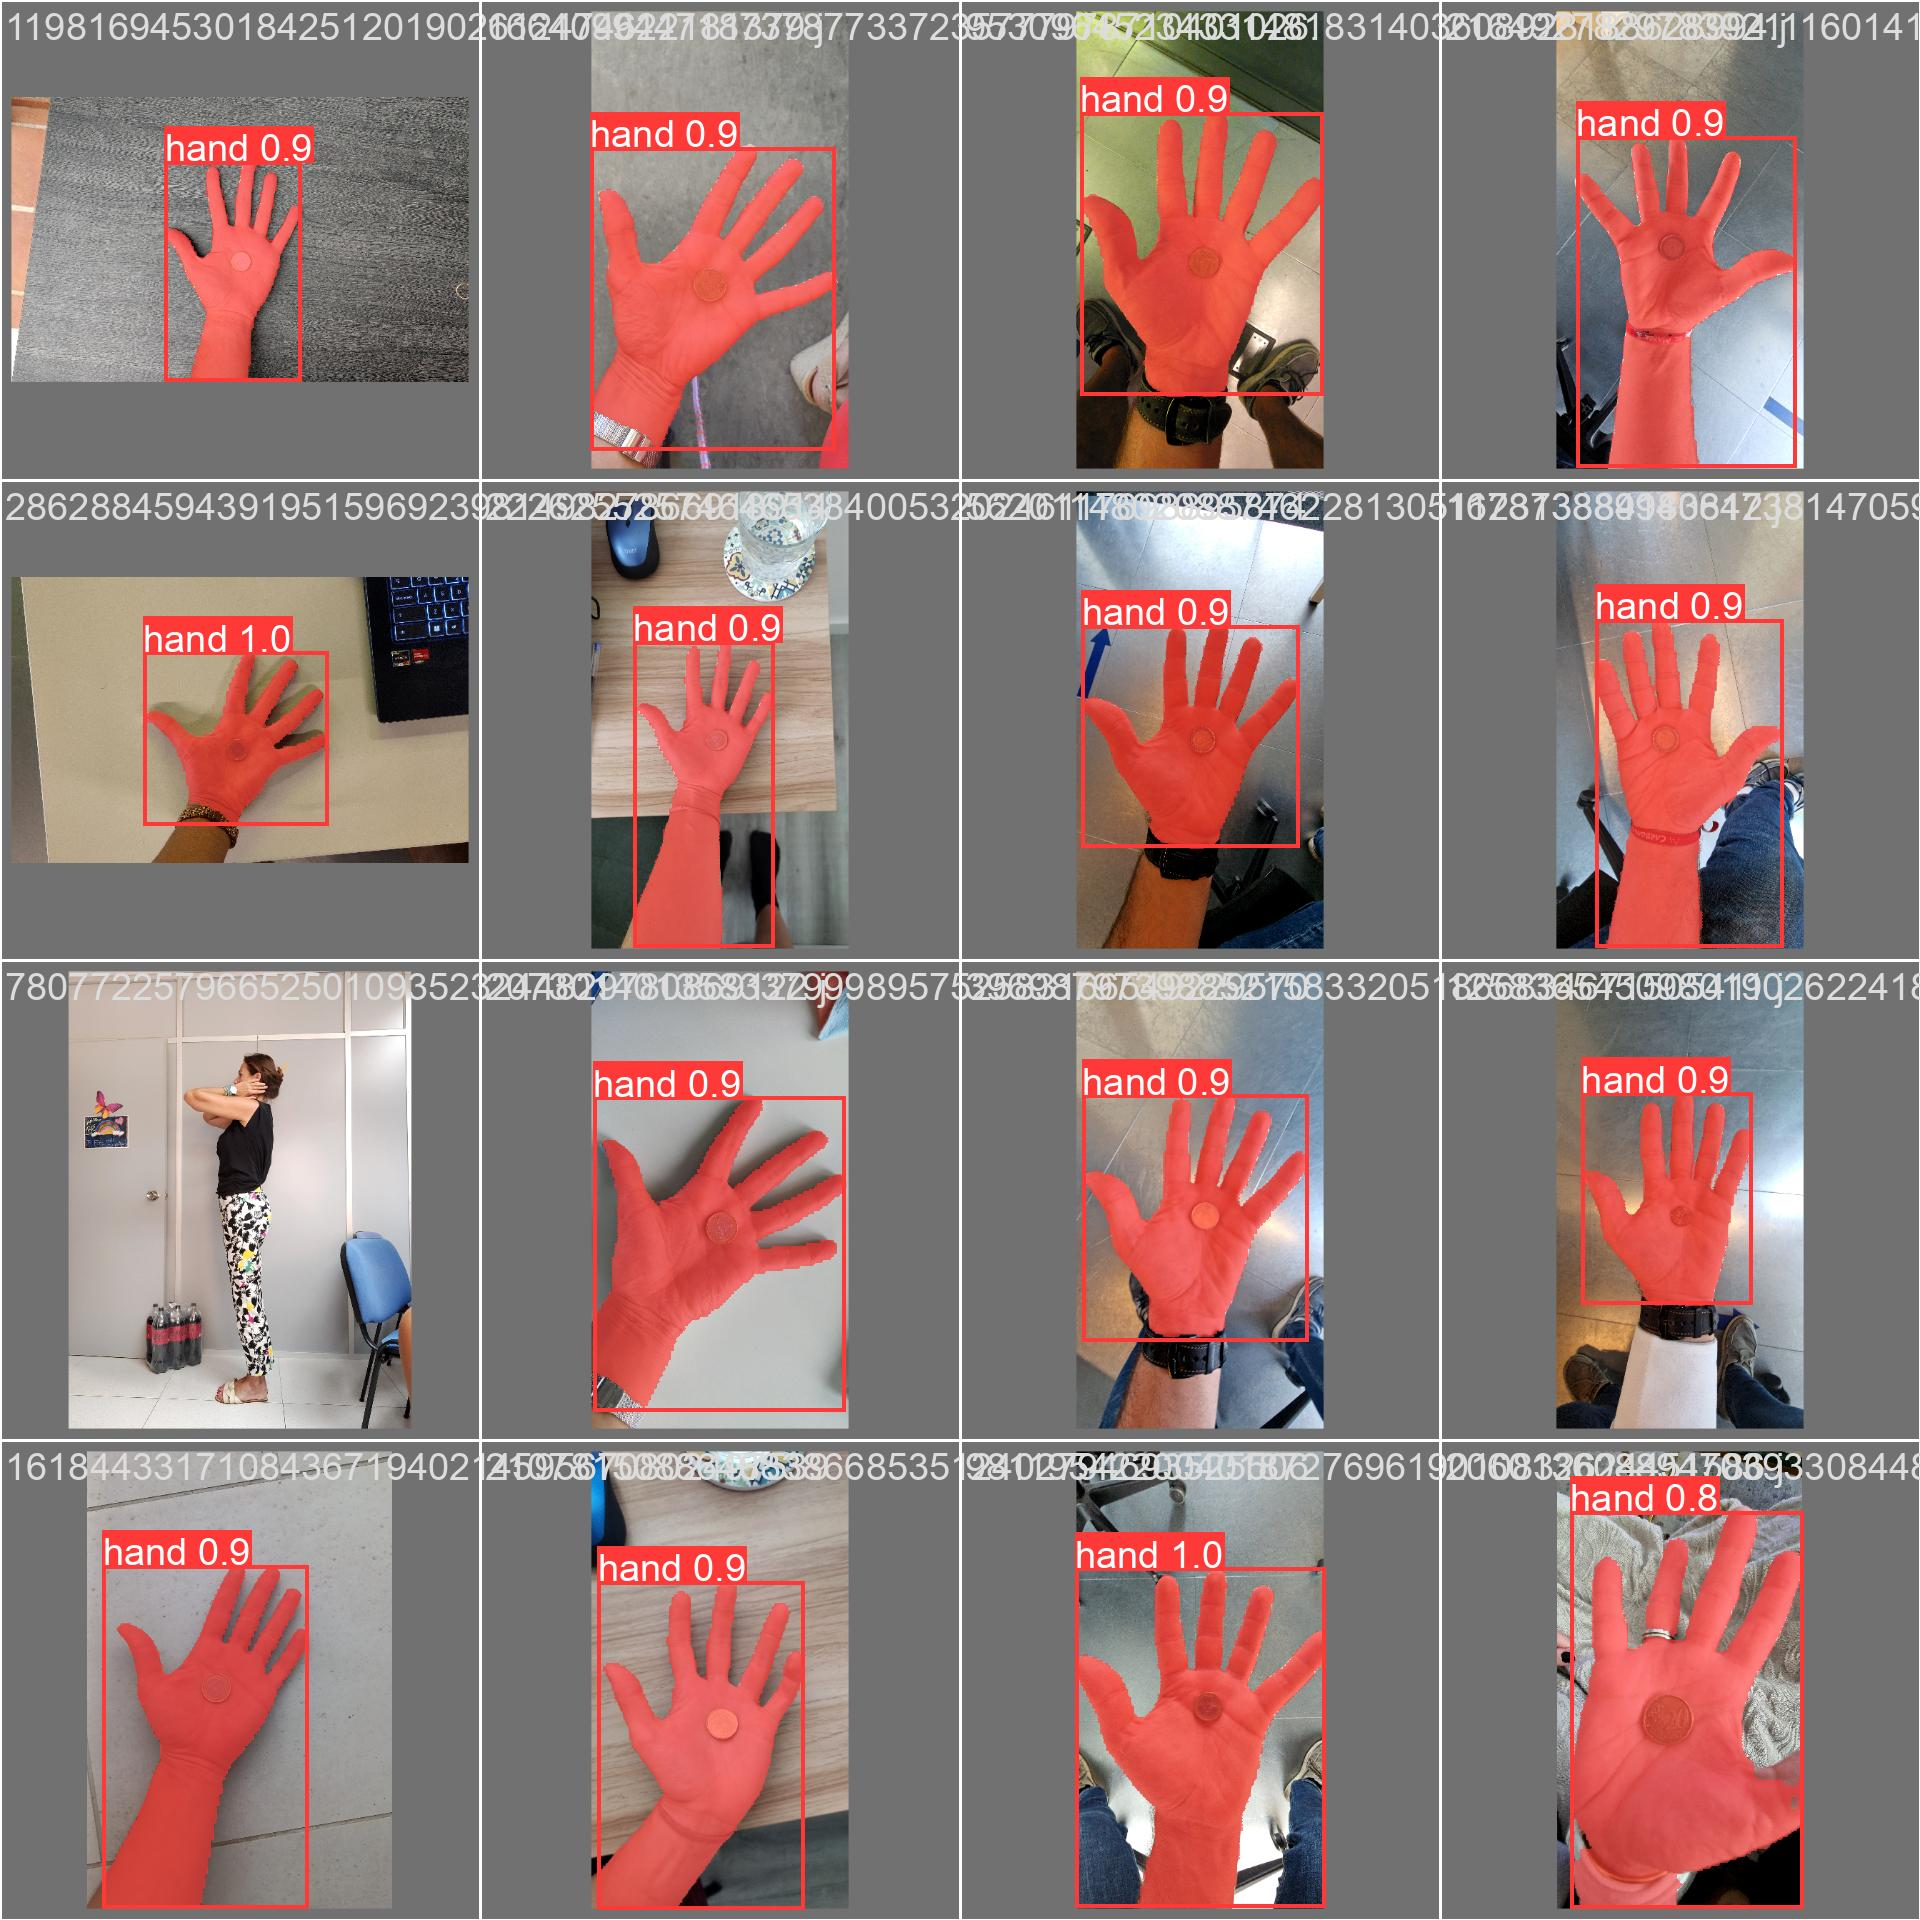

In [ ]:
Image(filename='./runs/segment/train/val_batch0_pred.jpg', width=600)

###Visualize the results of the validation phase.

In [ ]:
!yolo task=segment mode=val model=./runs/segment/train/weights/best.pt data=./datasets/dataset.yaml

Ultralytics YOLOv8.0.188 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients
val: Scanning /content/datasets/new_dataset/val.cache... 30 images, 0 backgrounds, 3 corrupt: 100% 30/30 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/new_dataset/val/176050944255569696171429208342549692420.jpeg: ignoring corrupt image/label: Label class 27 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/datasets/new_dataset/val/191919988383037687917443621465175818242.jpeg: ignoring corrupt image/label: Label class 51 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/datasets/new_dataset/val/213439783588959363575402189431796334594.jpeg: ignoring corrupt image/label: Label class 60 exceeds dataset class count 1. Possible class labels are 0-0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R

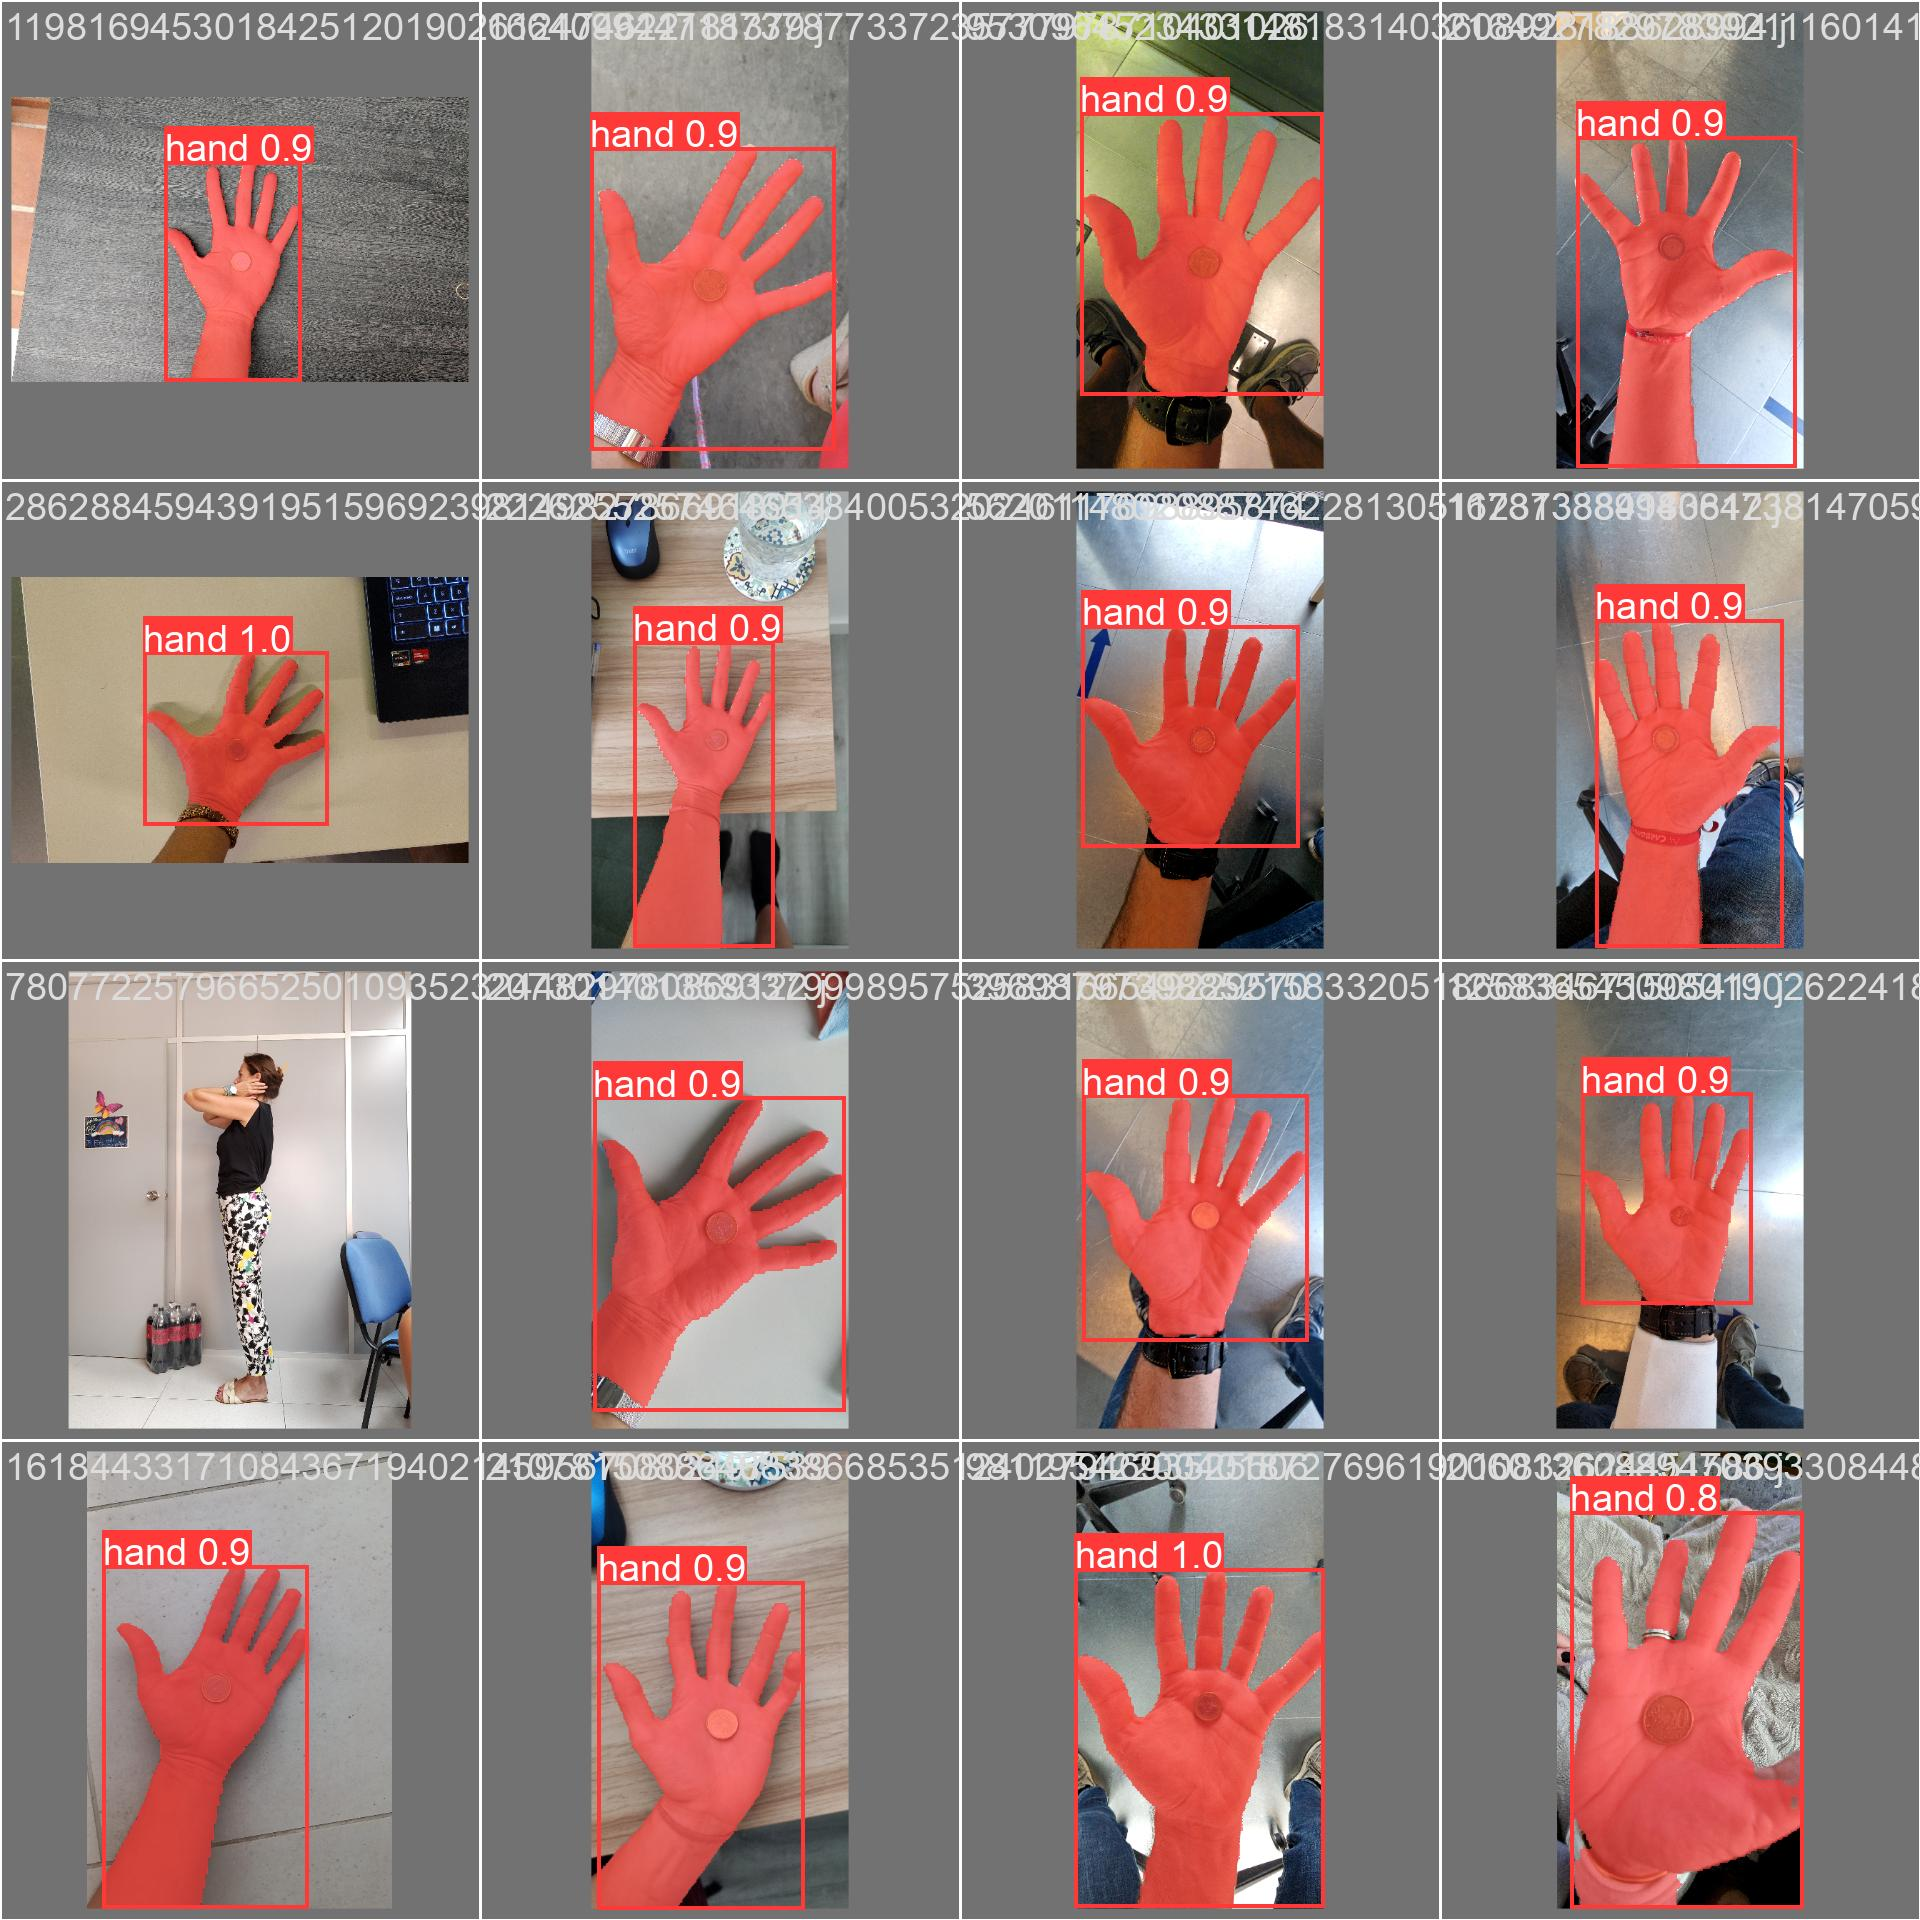

In [ ]:
Image(filename='./runs/segment/val/val_batch0_pred.jpg', width=600)

##Save the best model

**Now, save the weights of the best model, you can find it here `./runs/segment/train/weights/best.pt`**

#Background Removal

choose any image from val set to predict it

In [ ]:
from ultralytics import YOLO
model = YOLO('./runs/segment/train/weights/best.pt')
results = model.predict(
    source='/content/datasets/new_dataset/val/11981694530184251201902612474622181379.jpeg',
    conf=0.5,
    save=True
    )


image 1/1 /content/datasets/new_dataset/val/11981694530184251201902612474622181379.jpeg: 416x640 1 hand, 80.9ms
Speed: 2.6ms preprocess, 80.9ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/segment/predict


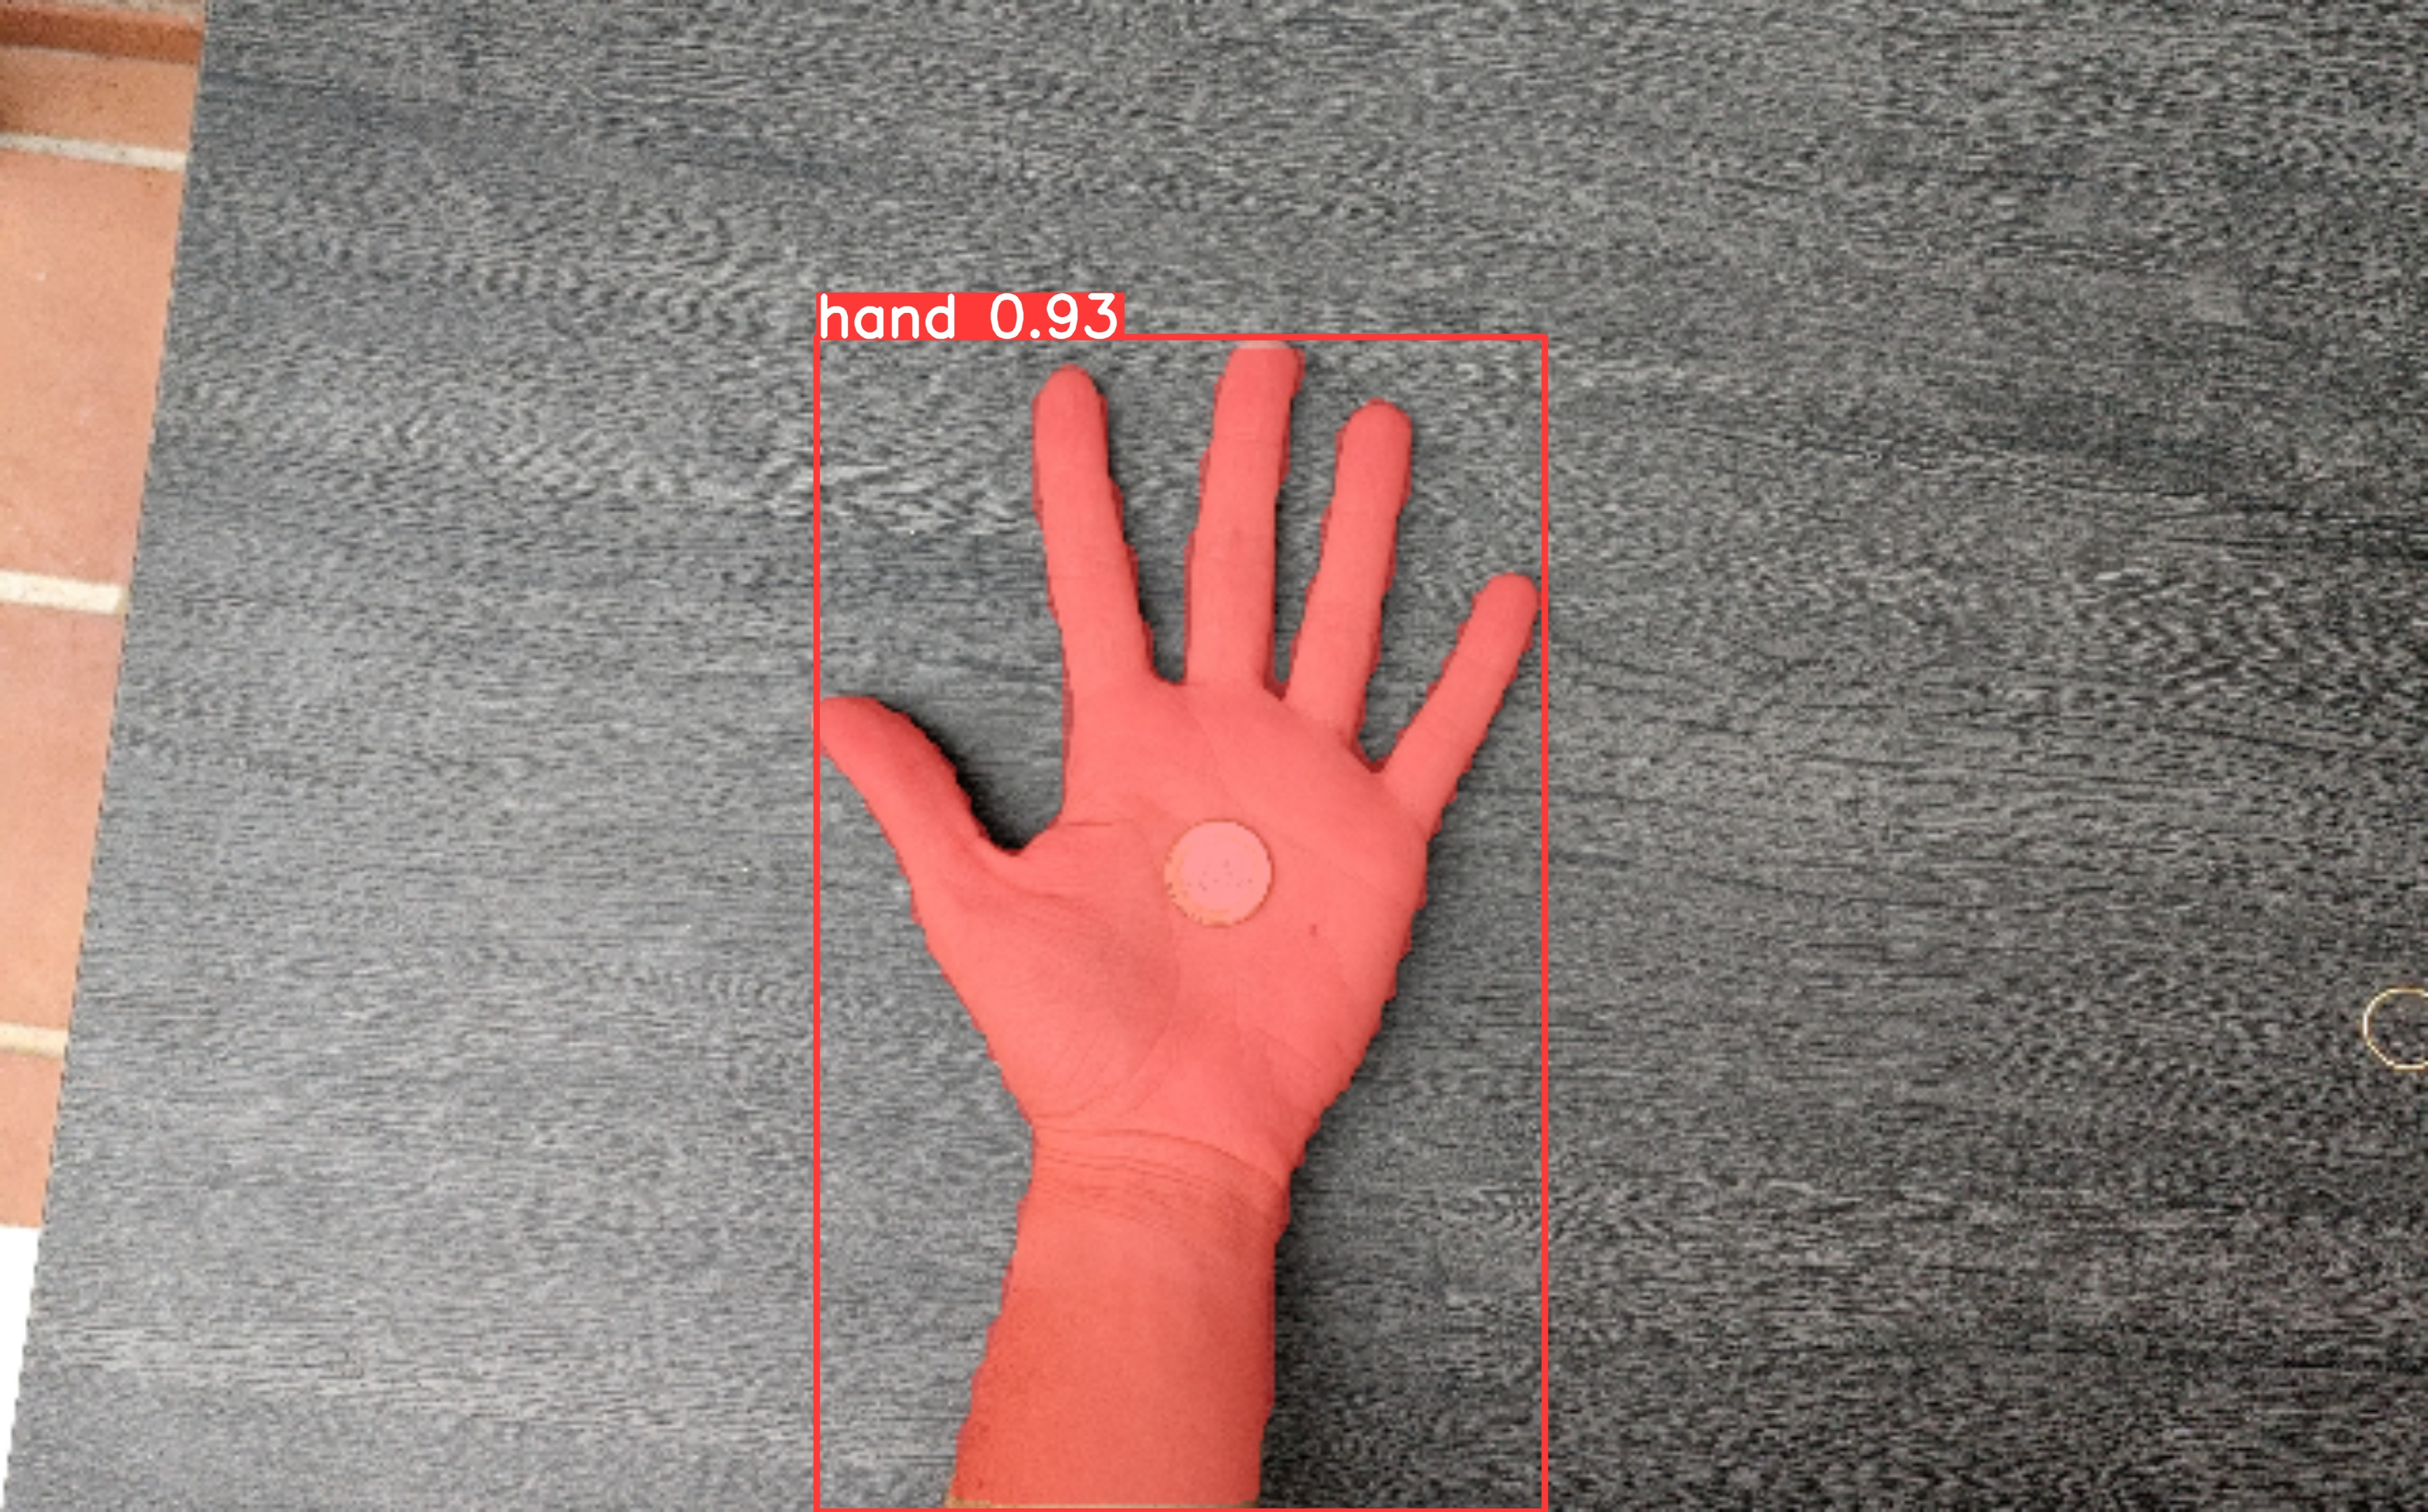

In [ ]:
Image(filename='/content/runs/segment/predict/11981694530184251201902612474622181379.jpeg',height=600, width=600)

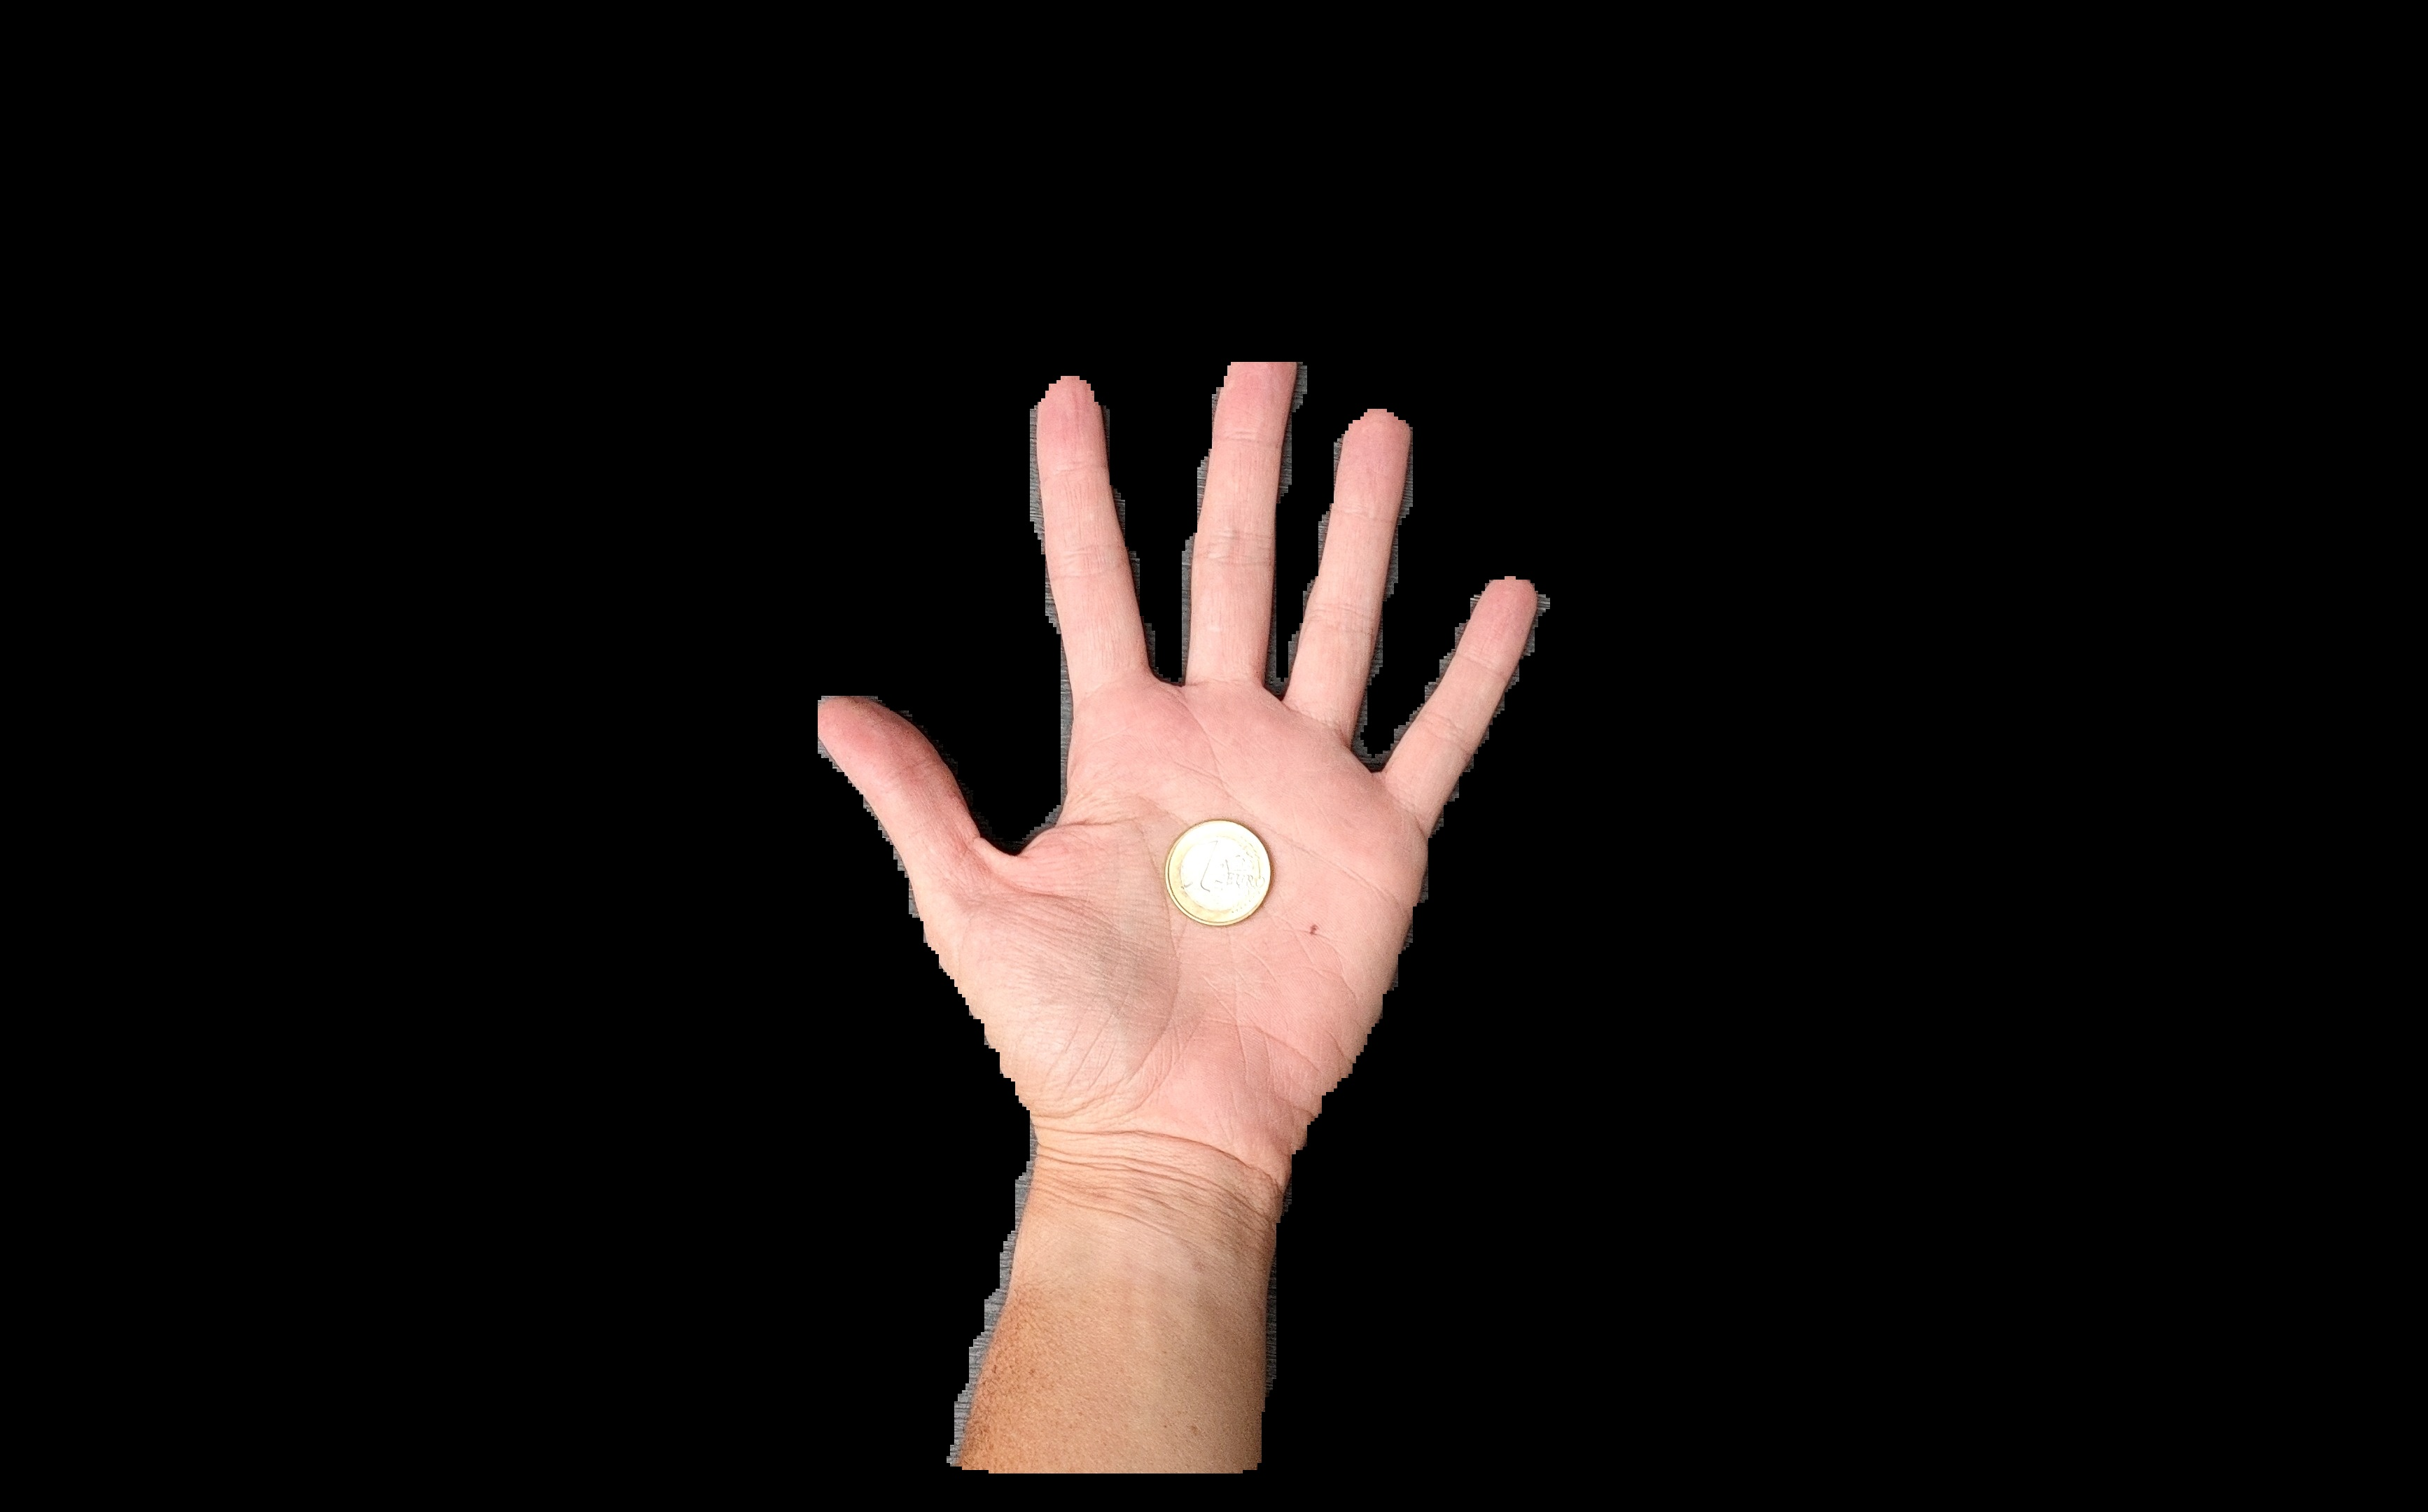

In [ ]:

if(results[0].masks is not None):
    # Convert mask to single channel image
    mask_raw = results[0].masks[0].cpu().data.numpy().transpose(1, 2, 0)

    # Convert single channel grayscale to 3 channel image
    mask_3channel = cv2.merge((mask_raw,mask_raw,mask_raw))

    # Get the size of the original image (height, width, channels)
    h2, w2, c2 = results[0].orig_img.shape

    # Resize the mask to the same size as the image (can probably be removed if image is the same size as the model)
    mask = cv2.resize(mask_3channel, (w2, h2))

    # Convert BGR to HSV
    hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

    # Define range of brightness in HSV
    lower_black = np.array([0,0,0])
    upper_black = np.array([0,0,1])

    # Create a mask. Threshold the HSV image to get everything black
    mask = cv2.inRange(mask, lower_black, upper_black)

    # Invert the mask to get everything but black
    mask = cv2.bitwise_not(mask)

    # Apply the mask to the original image
    masked = cv2.bitwise_and(results[0].orig_img, results[0].orig_img, mask=mask)

    # Show the masked part of the image
    cv2.imwrite('result.jpg',  masked)

Image(filename='result.jpg',height=800, width=800)